# TEXT CLASSIFICATION AND SENTIMENT ANALYSIS

In [42]:
# Import and settings
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pickle
pd.set_option('display.max_colwidth', 300)


In [43]:
# Load dataset
df = pd.read_csv('amazonreviews.tsv', sep='\t', encoding='utf-8')
print('Rows, Columns:', df.shape)
df.head()

Rows, Columns: (10000, 2)


,label,review
0,pos,Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crud...
1,pos,The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years ...
2,pos,"Amazing!: This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners of Fate"" (which means all the more if you've played the game) and the hope in ""A Distant Promise"" and ""Girl who Stole the Star"" have been an important inspiration to me personally throughout..."
3,pos,"Excellent Soundtrack: I truly like this soundtrack and I enjoy video game music. I have played this game and most of the music on here I enjoy and it's truly relaxing and peaceful.On disk one. my favorites are Scars Of Time, Between Life and Death, Forest Of Illusion, Fortress of Ancient Dragons..."
4,pos,"Remember, Pull Your Jaw Off The Floor After Hearing it: If you've played the game, you know how divine the music is! Every single song tells a story of the game, it's that good! The greatest songs are without a doubt, Chrono Cross: Time's Scar, Magical Dreamers: The Wind, The Stars, and the Sea ..."


In [46]:
# Quick data inspection
print(df['label'].value_counts())
print('\nMissing review counts:', df['review'].isna().sum())
print('\nduplicate rows:', df.duplicated().sum())

label
neg    5096
pos    4903
Name: count, dtype: int64

Missing review counts: 0

duplicate rows: 0


#### Data cleaning

In [47]:
# Data cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', ' ', text)  # remove URLs
    text = re.sub(r'[^a-z\s]', ' ', text)  # keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # collapse whitespace
    return text

df['clean_review'] = df['review'].fillna('').apply(clean_text)
# Remove exact duplicates (keeping first)
df = df.drop_duplicates(subset=['clean_review']).reset_index(drop=True)
print('After dropping duplicates:', df.shape)

After dropping duplicates: (9999, 3)


#### Exploratory analysis

In [48]:
# Exploratory analysis: distribution and most common words
print('Label distribution:\n', df['label'].value_counts(normalize=True))

# Top words by label (simple token counts)
from collections import Counter

def top_n_words(texts, n=20, stopwords=set(ENGLISH_STOP_WORDS)):
    cnt = Counter()
    for t in texts:
        for w in t.split():
            if w and w not in stopwords and len(w)>2:
                cnt[w]+=1
    return cnt.most_common(n)

print('\nTop words in positive reviews:')
print(top_n_words(df[df['label']=='pos']['clean_review'], 20))
print('\nTop words in negative reviews:')
print(top_n_words(df[df['label']=='neg']['clean_review'], 20))


Label distribution:
 label
neg    0.509651
pos    0.490349
Name: proportion, dtype: float64

Top words in positive reviews:
[('book', 3390), ('great', 2135), ('good', 1667), ('read', 1605), ('like', 1290), ('movie', 1121), ('just', 1036), ('time', 924), ('love', 911), ('really', 832), ('best', 813), ('story', 730), ('music', 576), ('books', 543), ('little', 529), ('think', 512), ('don', 510), ('album', 508), ('life', 503), ('recommend', 493)]

Top words in negative reviews:
[('book', 3277), ('like', 1569), ('just', 1526), ('movie', 1519), ('read', 1222), ('good', 1160), ('don', 1135), ('time', 1070), ('buy', 835), ('really', 783), ('money', 767), ('bad', 764), ('did', 684), ('better', 677), ('great', 644), ('story', 641), ('product', 630), ('work', 624), ('make', 550), ('didn', 540)]


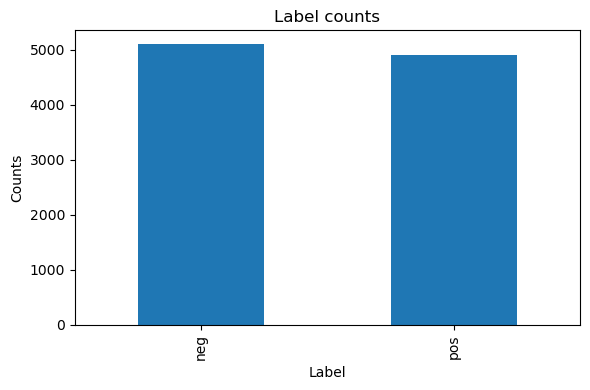

In [49]:
# Simple bar plot for label counts
plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar')
plt.title('Label counts')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.tight_layout()
plt.show()

#### Word Clouds Visualization

In [50]:
!pip install wordcloud


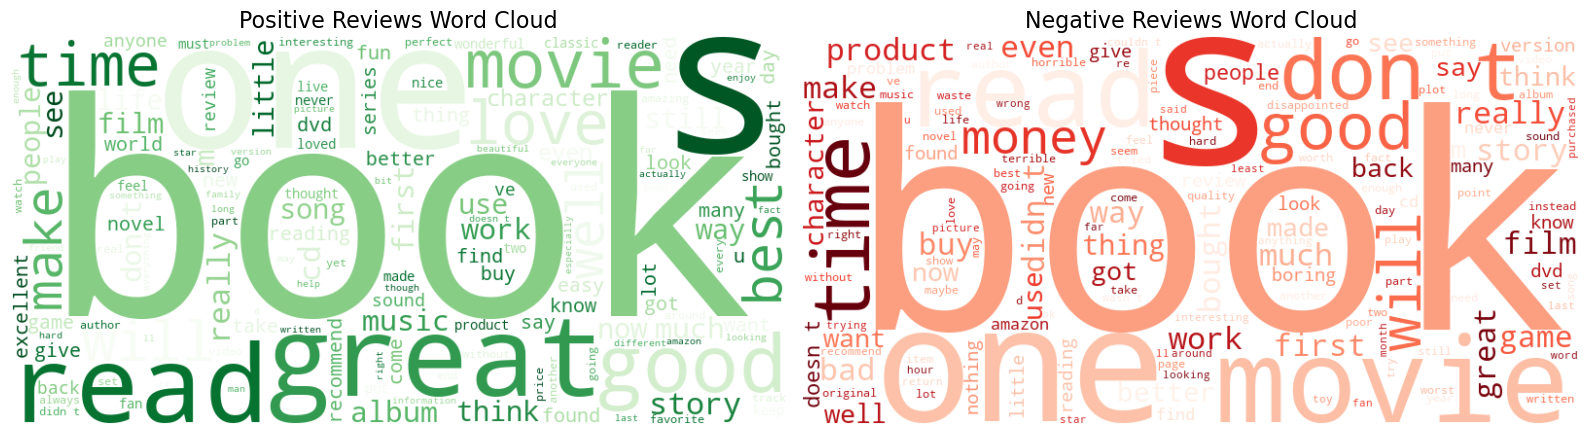

In [51]:
# Word Clouds for Positive and Negative Reviews
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds
pos_text = " ".join(df[df['label'] == 'pos']['clean_review'])
neg_text = " ".join(df[df['label'] == 'neg']['clean_review'])

# Create WordCloud objects
pos_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens', max_words=150).generate(pos_text)
neg_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds', max_words=150).generate(neg_text)

# Plot side by side
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.imshow(pos_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews Word Cloud", fontsize=16)

plt.subplot(1,2,2)
plt.imshow(neg_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews Word Cloud", fontsize=16)

plt.tight_layout()
plt.show()


### Model development

In [52]:
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(df['clean_review'])
y = df['label'].map({'pos':1,'neg':0}).values
print('X shape:', X.shape)

X shape: (9999, 10000)


In [53]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train size:', X_train.shape, 'Test size:', X_test.shape)

Train size: (7999, 10000) Test size: (2000, 10000)


In [54]:
# Train a Logistic Regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [55]:
# Evaluate on test set
y_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print('\nClassification report:\n', classification_report(y_test, y_pred, target_names=['neg','pos']))


Accuracy: 0.8555
F1 score: 0.8517188301693176

Classification report:
               precision    recall  f1-score   support

         neg       0.85      0.86      0.86      1019
         pos       0.86      0.85      0.85       981

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



Confusion matrix:
 [[881 138]
 [151 830]]


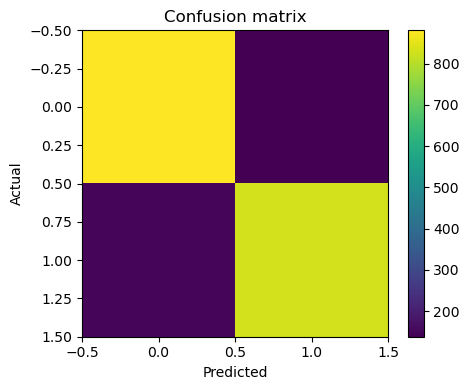

In [56]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.tight_layout()
plt.show()

In [57]:
# Cross-validation for model robustness (Accuracy & F1 Score)
from sklearn.model_selection import cross_val_score

cv_accuracy = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
cv_f1 = cross_val_score(clf, X, y, cv=5, scoring='f1')

print("Cross-Validation Results (5-Fold):")
print("----------------------------------")
print("Accuracy scores per fold:", np.round(cv_accuracy, 3))
print("F1 scores per fold:", np.round(cv_f1, 3))
print()
print("Mean CV Accuracy:", round(cv_accuracy.mean(), 4))
print("Mean CV F1 Score:", round(cv_f1.mean(), 4))


Cross-Validation Results (5-Fold):
----------------------------------
Accuracy scores per fold: [0.856 0.836 0.835 0.84  0.843]
F1 scores per fold: [0.854 0.832 0.829 0.839 0.842]

Mean CV Accuracy: 0.8421
Mean CV F1 Score: 0.8389


In [58]:
# Feature importance: top positive and negative coefficients
feature_names = vectorizer.get_feature_names_out()
coefs = clf.coef_[0]
pos_top_idx = np.argsort(coefs)[-20:][::-1]
neg_top_idx = np.argsort(coefs)[:20]
print('Top positive words:')
print([feature_names[i] for i in pos_top_idx])
print('\nTop negative words:')
print([feature_names[i] for i in neg_top_idx])

Top positive words:
['great', 'excellent', 'best', 'love', 'perfect', 'good', 'amazing', 'wonderful', 'easy', 'favorite', 'works', 'loved', 'loves', 'awesome', 'fun', 'highly', 'fantastic', 'heart', 'beautiful', 'comfortable']

Top negative words:
['boring', 'bad', 'worst', 'poor', 'disappointed', 'waste', 'money', 'disappointing', 'don', 'horrible', 'terrible', 'did', 'return', 'disappointment', 'received', 'doesn', 'idea', 'junk', 'awful', 'maybe']


In [59]:
# Save model and vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
with open('logreg_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

print("Saved vectorizer as 'tfidf_vectorizer.pkl' and model as 'logreg_model.pkl' in current folder.")

Saved vectorizer as 'tfidf_vectorizer.pkl' and model as 'logreg_model.pkl' in current folder.


In [60]:
# Test: Load model and make a sample prediction
import pickle

# Load saved model and vectorizer
with open('tfidf_vectorizer.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)

with open('logreg_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Trying a few example reviews
sample_reviews = [
    "This product is amazing! I really loved it.",
    "Terrible quality, completely disappointed.",
    "Works fine but not worth the price.",
    "Excellent purchase, highly recommend to everyone!"
]

# Transform and predict
X_sample = loaded_vectorizer.transform(sample_reviews)
preds = loaded_model.predict(X_sample)

# Map 1/0 to pos/neg
sentiments = ["pos" if p == 1 else "neg" for p in preds]

# Show results
for review, sentiment in zip(sample_reviews, sentiments):
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")


Review: This product is amazing! I really loved it.
Predicted Sentiment: pos

Review: Terrible quality, completely disappointed.
Predicted Sentiment: neg

Review: Works fine but not worth the price.
Predicted Sentiment: pos

Review: Excellent purchase, highly recommend to everyone!
Predicted Sentiment: pos



### Conclusion

This project built a sentiment analysis model using TF-IDF and Logistic Regression.Data was cleaned, explored, and evaluated using accuracy and F1-score. The model effectively classifies reviews as positive or negative. Future improvements include using word embeddings, advanced preprocessing, and hyperparameter tuning for better performance.
